In [48]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tools
import itertools

from sklearn import manifold
from sklearn import preprocessing
from sklearn import mixture

In [49]:
from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = '../training_data.csv'
df = pd.read_csv(filename)
df

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [50]:
df['Well Name'].unique()

array(['SHRIMPLIN', 'SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN',
       'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE'], dtype=object)

In [66]:
features = df.drop(['NM_M','RELPOS','Depth','Well Name','Formation','Facies'], axis=1)
features

,GR,ILD_log10,DeltaPHI,PHIND,PE
0,77.450,0.664,9.900,11.915,4.600
1,78.260,0.661,14.200,12.565,4.100
2,79.050,0.658,14.800,13.050,3.600
3,86.100,0.655,13.900,13.115,3.500
4,74.580,0.647,13.500,13.300,3.400
...,...,...,...,...,...
3227,46.719,0.947,1.828,7.254,3.617
3228,44.563,0.953,2.241,8.013,3.344
3229,49.719,0.964,2.925,8.013,3.190
3230,51.469,0.965,3.083,7.708,3.152


In [67]:
X = preprocessing.RobustScaler().fit_transform(features.values)
X = manifold.LocallyLinearEmbedding(n_components=5).fit_transform(X)
y = df['Facies'].values
wells = df["Well Name"].values

/Users/stevejpurves/anaconda3/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/stevejpurves/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/stevejpurves/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


     CHURCHMAN BIBLE  0.074
      CROSS H CATTLE  0.219
            LUKE G U  0.050
               NEWBY  0.069
               NOLAN  0.081
          Recruit F9  0.000
             SHANKLE  0.001
           SHRIMPLIN  0.027


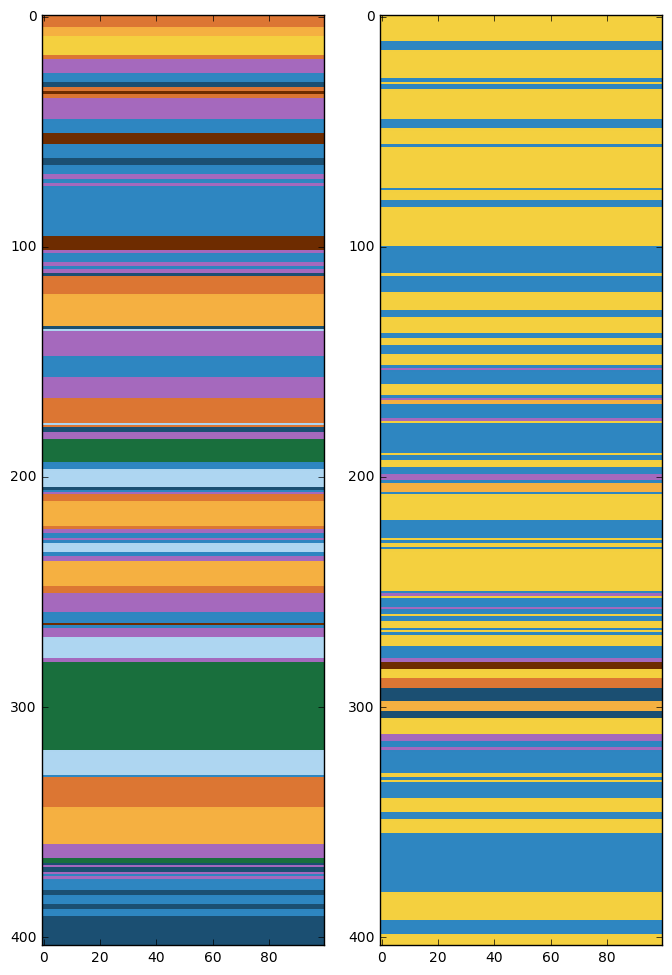

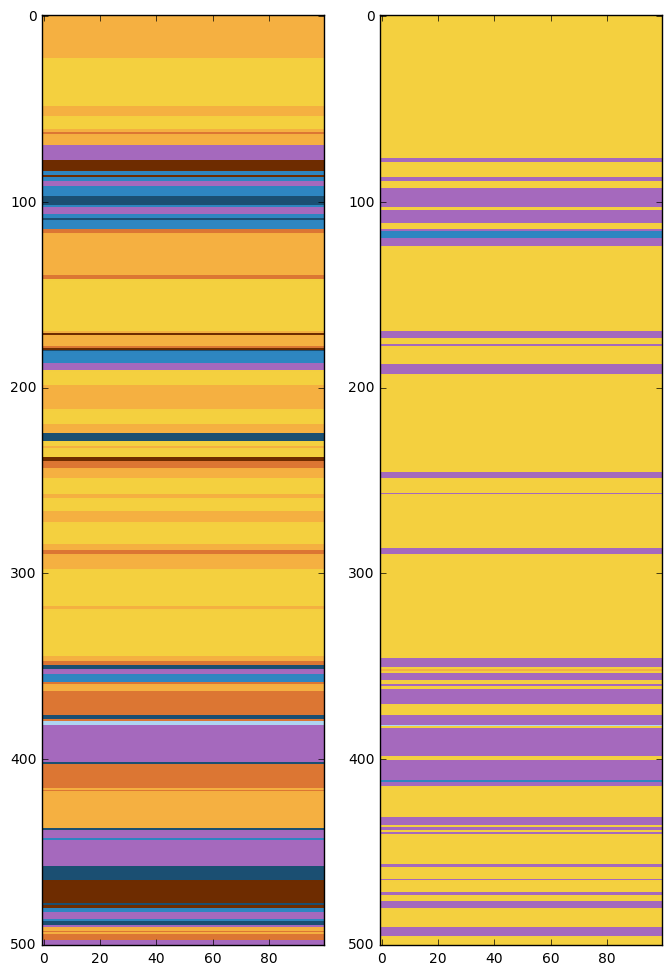

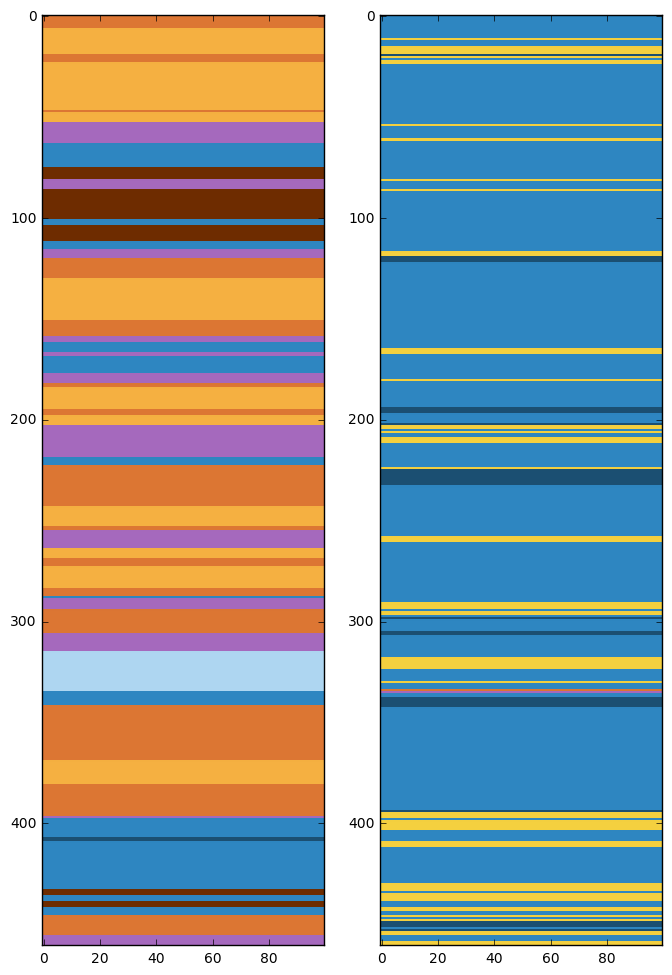

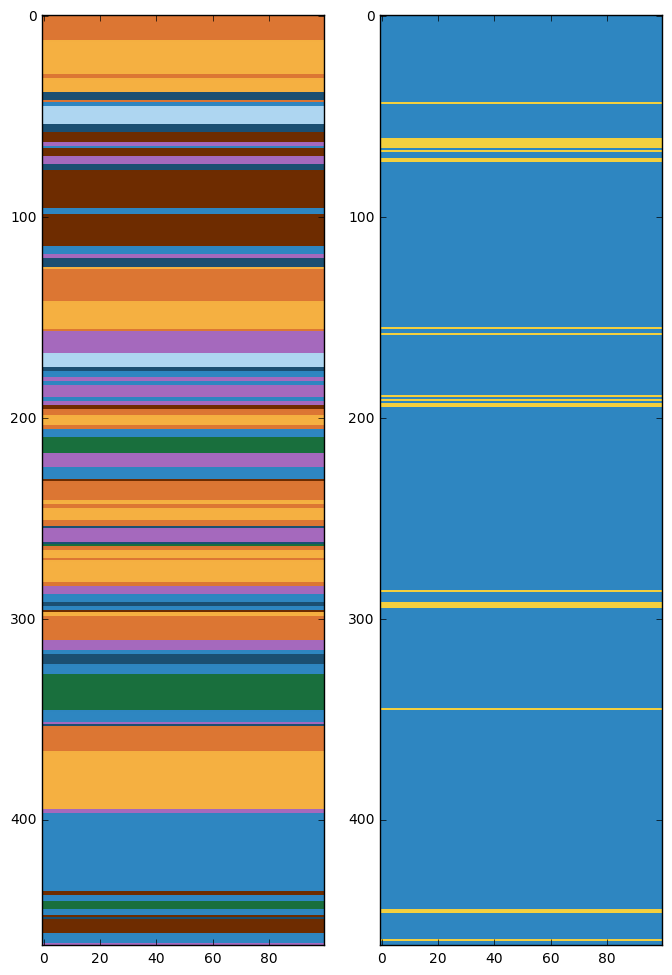

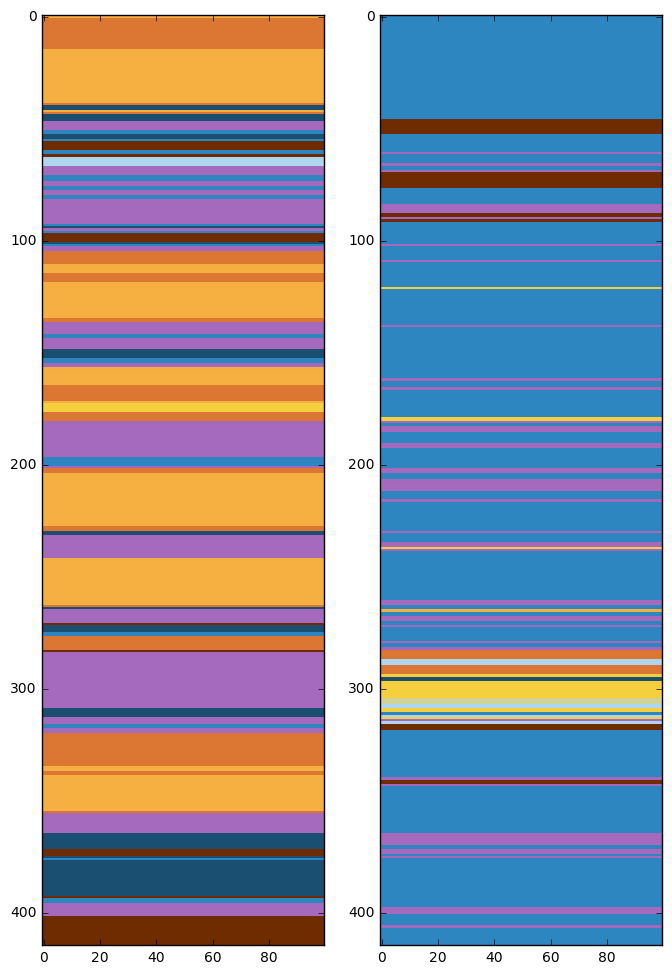

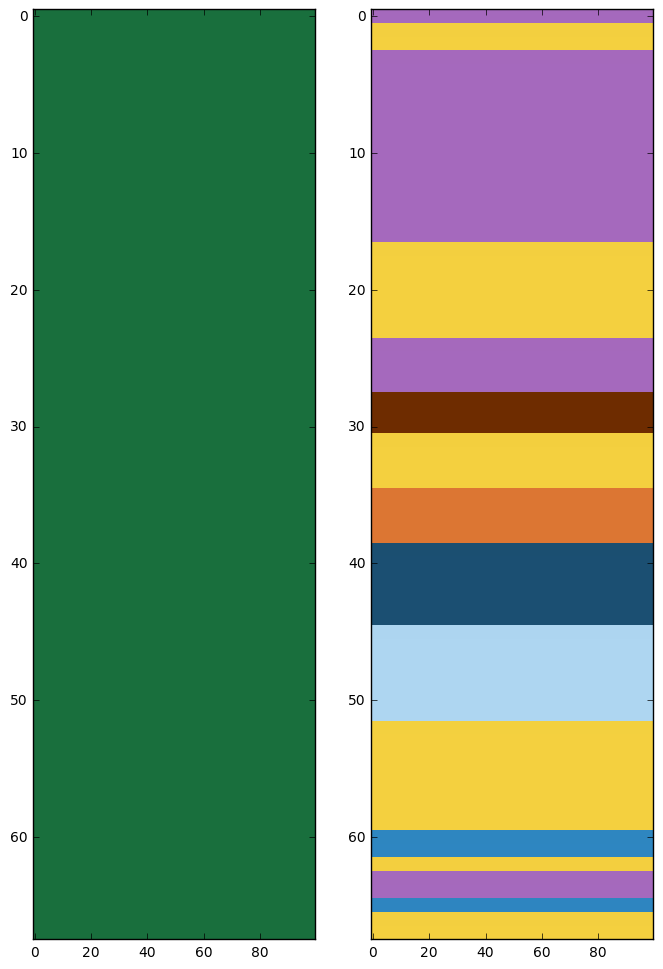

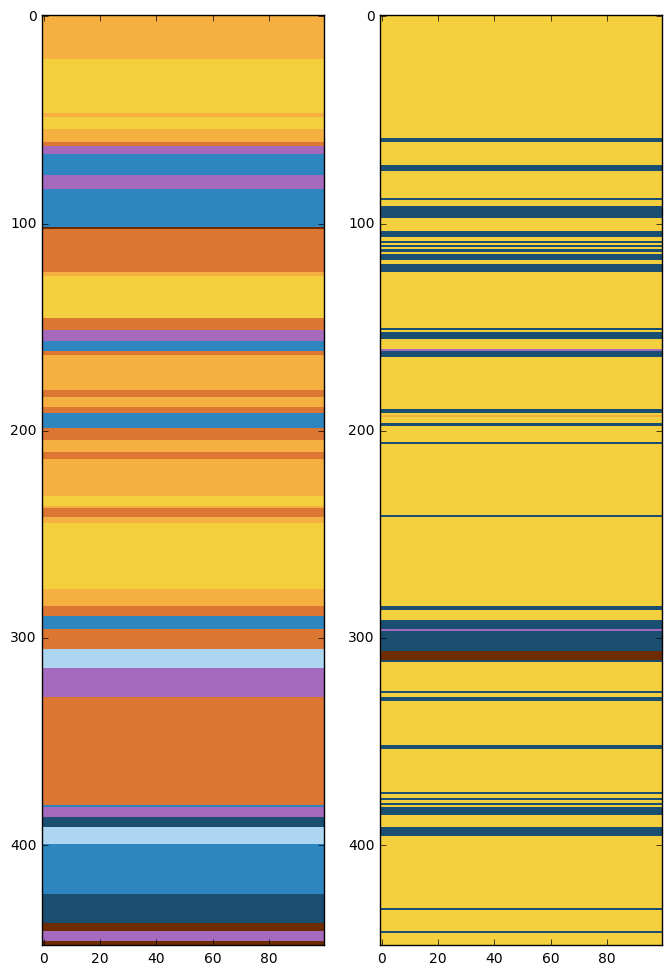

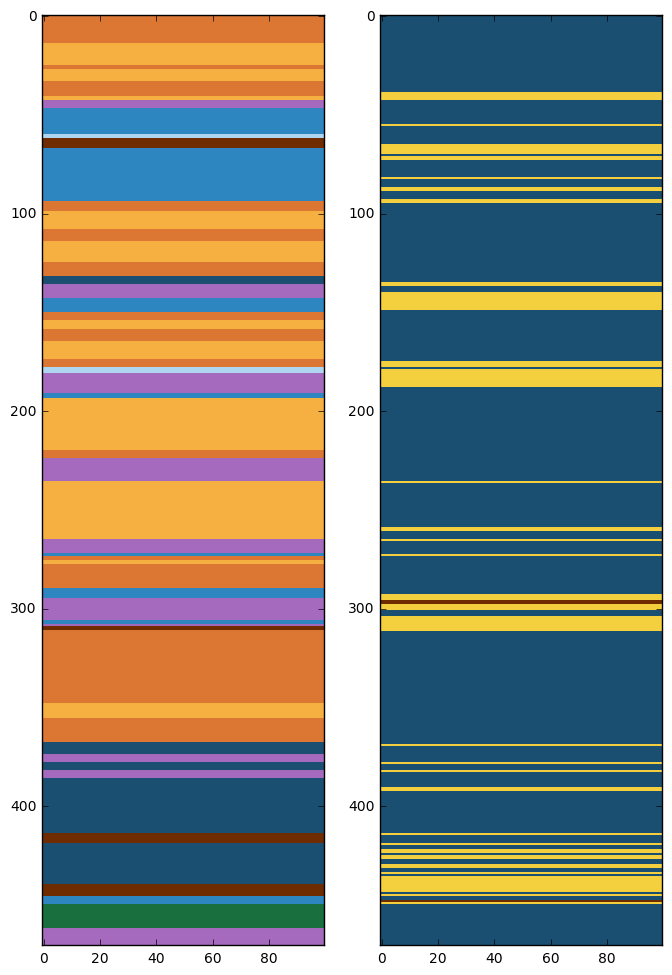

In [68]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import metrics

facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

logo = LeaveOneGroupOut()

cmap_facies = colors.ListedColormap(
        facies_colors[0:len(facies_colors)], 'indexed')

for train, test in logo.split(X, y, groups=wells):
    # Fit a Gaussian mixture with EM
    gmm = mixture.BayesianGaussianMixture(n_components=9, covariance_type='full',
                                          weight_concentration_prior=1000,
                                          init_params='kmeans',
                                          random_state=0)
    gmm.fit(X[train], y[train])
    yy = gmm.predict(X[test])
    well_name = wells[test[0]]
    score = metrics.f1_score(y[test], yy, average='weighted')
    print("{:>20s}  {:.3f}".format(well_name, score))
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 12))
    cluster_test=np.repeat(np.expand_dims(y[test],1), 100, 1)
    cluster_pred=np.repeat(np.expand_dims(yy,1), 100, 1)
    im=ax[0].imshow(cluster_test, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im=ax[1].imshow(cluster_pred, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)

